In [39]:
import torch
from torch import nn

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [41]:
# Importing data
mnist_train = datasets.FashionMNIST(root="./data", download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root="./data", download=True, train=False, transform=ToTensor())

In [42]:
from torch.utils.data import DataLoader

# Converting to dataloader
train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

In [43]:
# Defining model
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"), # Shape = 32, 28, 28
        nn.MaxPool2d(kernel_size=2), # Shape = 32, 14, 14
        nn.BatchNorm2d(32), # Normalizing data
        nn.ReLU(), # Breaking linearity
        nn.Dropout(0.1) # Dropout 10 % of connections
    ),

    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"), # Shape = 64, 14, 14
        nn.MaxPool2d(kernel_size=2), # Shape = 64, 7, 7
        nn.BatchNorm2d(64), # Normalizing data
        nn.ReLU(), # Breaking linearity
        nn.Dropout(0.1) # Dropout 10 % of connections
    ),

    nn.Flatten(),

    nn.Sequential(
        nn.Linear(3136, 1000), # Shape = 64 * 7 * 7 = 3136
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.3), # Dropout 30 % of connections

        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.5), # Dropout 50 % of connections
        nn.Linear(100, 10)
    )
).to(device)

# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Training loop
train_losses = []
test_losses = []

for i in range(10):
    model.train()
    train_loss_sum = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = nn.functional.one_hot(y, num_classes=10).type(torch.float32).to(device) # Implementing one hot encoding and placing on cuda

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
    train_losses.append(train_loss_sum / len(train_dataloader))

    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = nn.functional.one_hot(y, num_classes=10).type(torch.float32).to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            test_loss_sum += loss.item()
        test_losses.append(test_loss_sum / len(test_dataloader))

    torch.save(model.state_dict(), 'models/model_' + str(i) + '.pth')

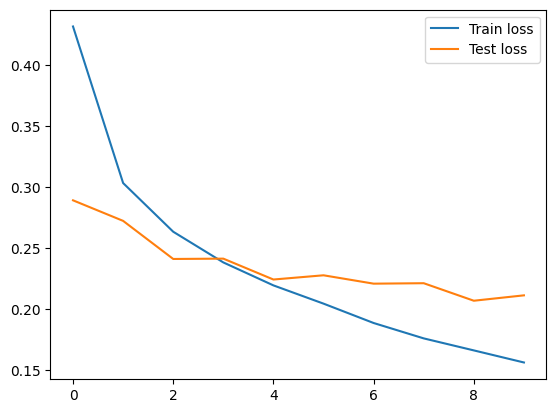

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

We can see that after 4 iterations, the model keeps trying to learn. This is not convenient because it can be learning noise for example, resulting on overfiting.

In [46]:
# Model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)                   # logits
        preds = y_pred.argmax(dim=1)        # índice da classe com maior valor
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 92.70%


So, it is necessary to reduce the number of iterations, in this case, I am going to import the saved model of iteration 4 (model_4) to see if the overfiting is improved.

In [52]:
# Importing weights from the model_5
model.load_state_dict(torch.load('models/model_4.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [53]:
# Model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)                   # logits
        preds = y_pred.argmax(dim=1)        # índice da classe com maior valor
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 91.89%
